# Atlas creation: Yang data using Panglao method

Creating an atlas for gestational day 3.5. Note that this comprises the following steps:

1. Unsupervised clustering of raw scRNAseq dayta
2. Coarse imputation of the identities of the scRNAseq data clusters
3. Manual fine-grained imputation of the identities of the scRNAseq clusters

This notebook covers one possibility that can satisfy Steps 1 and 2 of the pipeline. To do this, we will use data from the following publication:

> Yang, Y., Zhu, Q., & Liu, J. (2021). Deciphering mouse uterine receptivity for embryo implantation at single‐cell resolution. Cell Proliferation, 54(11), e13128. https://doi.org/10.1111/cpr.13128

**To do**

* Determine if using the top $n$ marker genes across clusters leads to better performance.

In [28]:
# Import published libraries
library(SingleR)
library(Seurat)
library(SeuratDisk)
library(readxl)
library(devtools)
library(ggplot2)
library(data.table)
library(dplyr)
library(purrr)

# custom DeMayo lab single-cell functions and data
devtools::load_all(path='../../rlib/dmSC')

ℹ Loading dmSC


## Step 1: load in and process Yang's single-cell dataset

Read in GD 4 (GD 3.5 as per our definition) and subject it to the usual preprocessing. This is entirely done by the `dmSC::preprocessingFunction` function.

In [2]:
# Read the raw assay data.
exprAssay = Seurat::Read10X(data.dir='./data/Cell Prolif 2021 GD2.5-3.5 scRNA-seq mouse uterus data/d3d4/d4')
head(exprAssay[,1:20])

  [[ suppressing 20 column names ‘AAACCCAAGTACGAGC-1’, ‘AAACCCACAGGTCTCG-1’, ‘AAACCCAGTCAGATTC-1’ ... ]]



6 x 20 sparse Matrix of class "dgCMatrix"
                                               
Xkr4    . . 1 . . . . . . . . . . . . . . . . .
Gm1992  . . . . . . . . . . . . . . . . . . . .
Gm37381 . . . . . . . . . . . . . . . . . . . .
Rp1     . . . . . . . . . . . . . . . . . . . .
Sox17   . . . 2 . . . . . . . . . . . . 6 . . .
Gm37323 . . . . . . . . . . . . . . . . . . . .

In [3]:
# Package the count matrix into a Seurat object.
st = CreateSeuratObject(counts=exprAssay, project='YangAtlas')
st

An object of class Seurat 
31053 features across 7240 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

In [4]:
# Subject the Seurat object to preprocessing.
stProc = dmSC::preprocessingFunction(st)[['after']]
stProc

An object of class Seurat 
20916 features across 6486 samples within 2 assays 
Active assay: ENSEMBLRNA (10281 features, 0 variable features)
 1 other assay present: RNA

An object of class Seurat 
20916 features across 6486 samples within 2 assays 
Active assay: ENSEMBLRNA (10281 features, 2000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

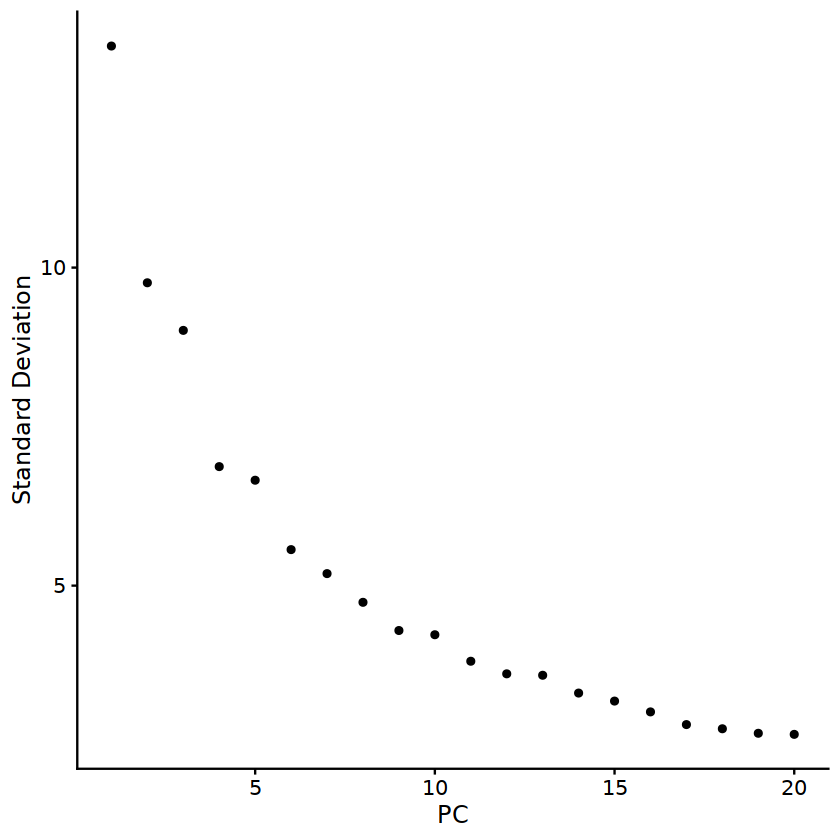

In [5]:
# Run PCA.
stProc = FindVariableFeatures(stProc)
stProc = ScaleData(stProc, verbose=FALSE)
stProc = RunPCA(stProc, verbose=FALSE)

stProc
ElbowPlot(stProc)

In [6]:
# No clear elbow, so just using 20 PCs. Confirm that this is the correct approach to take.
stProc = FindNeighbors(stProc, verbose=FALSE)
stProc = FindClusters(stProc, verbose=FALSE)
stProc = RunUMAP(stProc, reduction="pca", dims=1:20, verbose=FALSE)
stProc

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


An object of class Seurat 
20916 features across 6486 samples within 2 assays 
Active assay: ENSEMBLRNA (10281 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

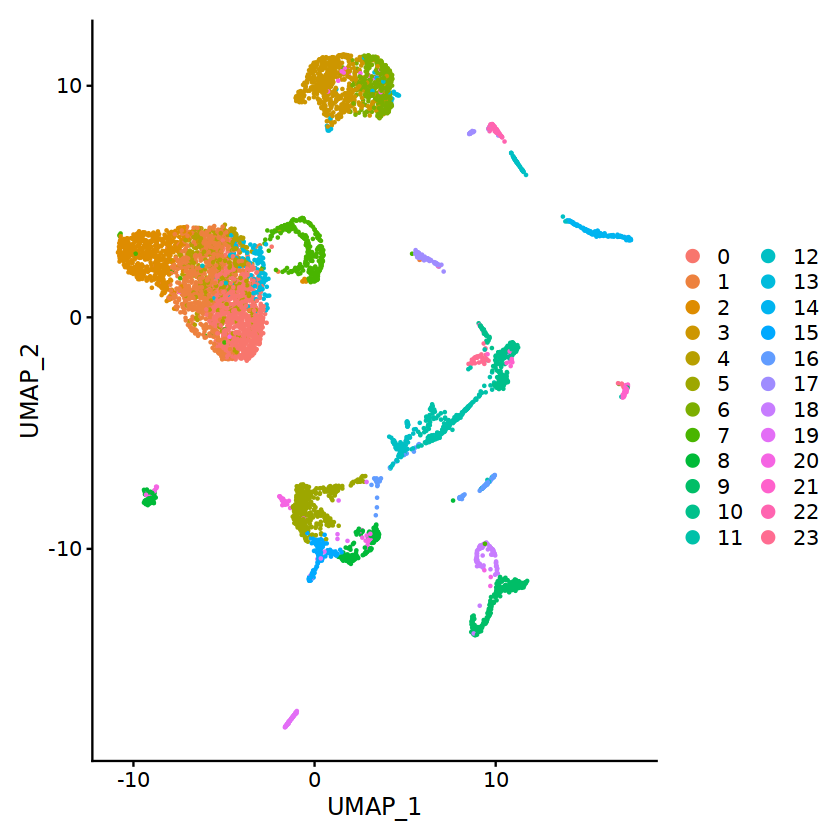

In [7]:
DimPlot(stProc)

## Step 2: Impute the clusters in a coarse clustering approach

### Step 2a: Read the PanglaoDB method

To determine the cell type of a cell cluster, we perform the following steps:

1. For every cell cluster $k$ in a sample $s$, we iterate over all genes $i = 1 \dots N$ and calculate the median expression per gene over normalized gene expression measurements so that gene expression for a cell cluster is represented by a vector $v_{s,k,i}$.
2. The cell-type identity is then determined using the collection of cell-type marker genes.
    * Some marker genes are found in multiple cell types and are less informative for cell-type inference. A simple workaround for such ‘multi cell type’ markers would be to remove them. However, removing markers would decrease sensitivity and inflate type II errors. We decided to use down-weighing of genes based on their frequency, an idea borrowed from gene set analysis, which relates the weight $w(g)$ for a gene to its frequency across gene sets (cell types in our case), $f(g)$, using a monotonically decreasing function:
    $$ w(g) = 1 + \sqrt\frac{\max(f) − f(g)}{\max(f) − \min(f)}. $$
    Thus, weights are bounded between 1 and 2, where genes occurring in many cell types receive weights closer to 1 and more specific genes will get doubled weights ($w = 2$).
3. Next, to define the putative cell type, we calculated a cell-type activity (CTA) score, similar to (21), for all of the >150 possible cell types. The CTA score estimates the ‘activity’ of marker genes, down-weighing the contribution of broad markers and adjusting the score for the total number of markers for the cell type:
$$S_{j,k} = \left(\sum^N_{i=1} Z_{k,j,i} \cdot w_i \right)/\sqrt[3]{N}.$$
$S_{j,k}$ is the CTA score for cell-type $j$ in cell cluster $k$ and $N$ is the total number of marker genes. $Z$ is normalized gene expression counts. For a given cell cluster, CTA scores are then ranked from highest to lowest and the top-ranking cell type is selected as the ‘winner’. A $P$ value is computed using a one-sided Fisher’s exact test (hypergeometric test) on genes being expressed and not. Genes were defined as expressed if expression was >0. A false discovery rate was calculated with the Benjamini–Hochberg procedure; if the adjusted $P$ value is >0.05 for the top-ranking cell type, it is set to ‘Unknown’.

**This is currently implemented in the Python package [`adobo`](https://github.com/oscar-franzen/adobo/tree/master), which is implemented online in the [`alona`](https://alona.panglaodb.se/index.html) tool.** Looking through the `adobo.bio.cell_type_predict` code shows that the method indeed follows the one advertised in the paper.

Note that `alona` will re-normalize our data as a part of preprocessing; just record the parameters you used.

### Step 2b: Prepare the data for PanglaoDB method

According to the tool, we need two things:

1. A single-cell expression matrix. We can simply export the matrix stored in `stProc`. Note in the documentation that genes need to be in symbol format, not ENSEMBL IDs. However, we use ENSEMBL IDs anyway because we will use `adobo` to change them to symbols since it compares markers against Gencode symbols in its internal database. `adobo` has its own function to convert ENSEMBL IDs to symbols, so I'll just use those functions to ensure the ENSEMBL IDs of our genes map to symbols in its database.
2. A list of marker genes for cell types. These come from the Yang data and are delimited by semicolons; this has no other purpose than being done for compatibility with the `alona` web tool (which seems to be nonfunctional).

In [8]:
# Get the pure count data (exprMatrix) with gene symbols.
exprMatrix = GetAssayData(stProc, slot='counts')
rownames(exprMatrix) = dmSC::applyMapper(rownames(exprMatrix), toEnsembl=FALSE)
head(exprMatrix[,1:10])
dim(exprMatrix)

  [[ suppressing 10 column names ‘AAACCCAAGTACGAGC-1’, ‘AAACCCACAGGTCTCG-1’, ‘AAACCCAGTCAGATTC-1’ ... ]]



6 x 10 sparse Matrix of class "dgCMatrix"
                           
Sox17   . . . . . . . . . .
Mrpl15  . . 2 3 1 2 . 1 1 4
Lypla1  . . 2 2 . . . . 1 .
Tcea1   . 1 2 4 2 2 . 5 2 2
Atp6v1h . . . . . . . 1 . 1
Rb1cc1  . . 3 2 2 2 . 3 . 2

[1] 10281  6486

In [9]:
# Get the list of gene names in the format alona expects.
cell_marker_path = "./data/Cell Prolif 2021 GD2.5-3.5 scRNA-seq mouse uterus data/Cell Prolif 2021_Table S1_scRNAseq GD2.5-3.5 cell marker genes.xls"
cellMarkers = read_excel(cell_marker_path, skip=2)
head(cellMarkers)

gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cd79a,7.966442e-212,3.392996,0.895,0.028,1.622446e-207,B
Igkc,6.015417e-21,3.251981,0.895,0.532,1.225100e-16,B
Ighm,1.234333e-62,3.155810,0.921,0.123,2.513843e-58,B
Cd79b,5.311253e-289,2.788107,0.868,0.018,1.081690e-284,B
Iglc2,0.000000e+00,2.682382,0.684,0.006,0.000000e+00,B
Ms4a1,0.000000e+00,2.596779,0.763,0.001,0.000000e+00,B


In [12]:
cell_markers_top20 <- cellMarkers %>% group_by(cell_type) %>% slice_max(order_by=avg_logFC, n=20)
cell_markers_top20 %>% slice_max(order_by=avg_logFC, n=1)

gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cell_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cd79a,7.966442e-212,3.392996,0.895,0.028,1.622446e-207,B
Cd74,0.000000e+00,3.046195,0.957,0.235,0.000000e+00,DC
Gm26917,3.281356e-125,5.297434,0.741,0.619,6.682809e-121,E
Ccl21a,0.000000e+00,5.447807,0.929,0.030,0.000000e+00,LEC
Apoe,0.000000e+00,3.979252,0.989,0.701,0.000000e+00,M
Gzma,0.000000e+00,4.552514,0.900,0.022,0.000000e+00,NK
Ccl5,1.685253e-177,2.939321,0.525,0.060,3.432187e-173,NKT
Acta2,3.276622e-215,3.539771,0.946,0.189,6.673168e-211,PC
Igf1,0.000000e+00,2.046827,0.998,0.357,0.000000e+00,S1


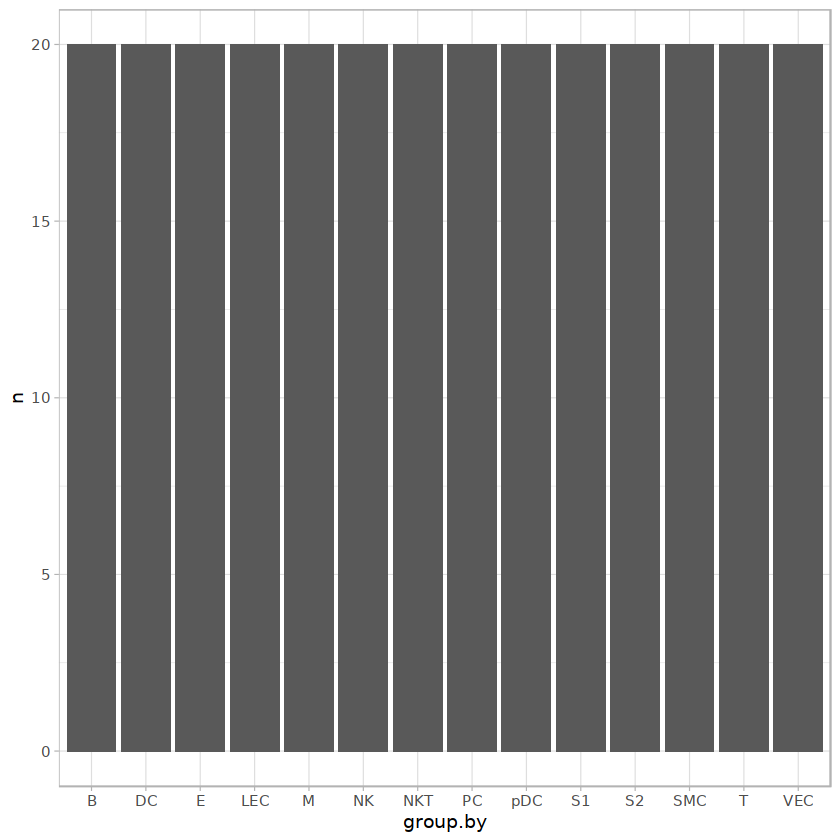

In [13]:
# Filter out the cell markers with low log fold-changes and insigificant p-values.
# Plot a distribution of marker types and ensure it is relatively uniform by eyeballing.
# As can be seen, this is not quite uniform. Perhaps taking the ten top marker genes for each cluster
# might lead to better results.
ggplot(cell_markers_top20 %>% count(group.by=cell_type), aes(x=group.by, y=n)) + geom_bar(stat="identity") + theme_light()

In [14]:
# Make a brief table of cell markers.
cellMarkersBrief = cell_markers_top20[,c('gene_symbol','cell_type')]
head(cellMarkersBrief)

gene_symbol,cell_type
<chr>,<chr>
Cd79a,B
Igkc,B
Ighm,B
Cd79b,B
Iglc2,B
Ms4a1,B


In [15]:
# Convert the gene names to ENSEMBL IDs, since we're not using PanglaoDB markers.
cellMarkersBriefENSEMBL = cellMarkersBrief
cellMarkersBriefENSEMBL[['gene_symbol']] = dmSC::applyMapper(cellMarkersBriefENSEMBL[['gene_symbol']], toEnsembl=TRUE)
cellMarkersBriefENSEMBL = cellMarkersBriefENSEMBL[!is.na(cellMarkersBriefENSEMBL[['gene_symbol']]),]
names(cellMarkersBriefENSEMBL)[1] = 'ensembl_id'
head(cellMarkersBriefENSEMBL)

ensembl_id,cell_type
<chr>,<chr>
ENSMUSG00000003379,B
ENSMUSG00000076609,B
ENSMUSG00000076617,B
ENSMUSG00000040592,B
ENSMUSG00000076937,B
ENSMUSG00000024673,B


In [16]:
# Write everything to disk.
fwrite(as.data.frame(exprMatrix), file='./analysis/alona/112223-yangExprMtx.csv.gz',
       row.names=TRUE, col.names=TRUE, compress='gzip')
fwrite(cellMarkersBrief, file='./analysis/alona/112223-yangMarkerGenes-Top20.txt',
       sep=';',row.names=FALSE, col.names=TRUE)
fwrite(cellMarkersBriefENSEMBL, file='./analysis/alona/112223-yangMarkerGenesENSEMBL-Top20.txt',
       sep=';',row.names=FALSE, col.names=TRUE)

### Step 2c: Impute the clusters (not coarse clustering)

This is just to test whether we can impute the cell-types present in the single-cell data. Coarse clustering will come after later discussion with Ryan about how to group the cell types.

Note that all code for imputing the clusters is in [the `111323-AdoboCellTypePrediction.ipynb` notebook.](./111323-AdoboCellTypePrediction.ipynb)

In [17]:
# Get rid of the scaled counts first--this messes with things when exporting.
scProcDiet <- DietSeurat(stProc, counts = FALSE, data = TRUE, scale.data = FALSE,
                         dimreducs = c("pca", "umap"))
scProcDiet

An object of class Seurat 
20916 features across 6486 samples within 2 assays 
Active assay: ENSEMBLRNA (10281 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [44]:
# Convert to AnnData object.
SaveH5Seurat(scProcDiet, filename = "./data/112223-YangData.h5Seurat")
Convert("./data/112223-YangData.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for ENSEMBLRNA

Adding variable features for ENSEMBLRNA

Adding feature-level metadata for ENSEMBLRNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding data from ENSEMBLRNA as X

Transfering meta.features to var

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap



## Step 3: Load the imputation results and visualize

Store these results in a separate metadata slot of the resultant Seurat atlas object. Confirm that the results here match the results that were given by `adobo`'s visualization.

* **Bug:** Mapper tables that don't have the 'V1,V2' headers don't work with applyMapper. Fix that soon.

In [18]:
# Read in the mapping table describing the relationships between the original clusters and Yang's clusters.
panglaoMapperTable = fread('./analysis/112223-imputedClusterMapperTable-Top20.csv')
colnames(panglaoMapperTable) = c('V1','V2')
panglaoMapperTable[['V1']] = as.character(panglaoMapperTable[['V1']])
head(panglaoMapperTable)

V1,V2
<chr>,<chr>
0,S1
1,S1
2,S1
3,S2
4,S1
5,M


In [19]:
# Store these clusters in a separate column of the metadata.
stProc[['panglao_clusters']] = dmSC::applyMapper(as.vector(unlist(stProc[['seurat_clusters']])),
                                                 mapperTable=panglaoMapperTable)
head(stProc[[]])

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,percent.ribo,nCount_ENSEMBLRNA,nFeature_ENSEMBLRNA,ENSEMBLRNA_snn_res.0.8,seurat_clusters,panglao_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>
AAACCCAAGTACGAGC-1,YangAtlas,5253,2001,6.281958,14.66399,5144,1949,8,8,DC
AAACCCACAGGTCTCG-1,YangAtlas,661,366,6.408346,30.55142,646,359,5,5,M
AAACCCAGTCAGATTC-1,YangAtlas,22942,4585,4.166667,31.95166,22555,4440,0,0,S1
AAACCCATCACGGACC-1,YangAtlas,26230,5149,3.706371,28.59742,25774,4996,2,2,S1
AAACCCATCGCTGTTC-1,YangAtlas,15773,3625,4.819732,38.15516,15514,3525,1,1,S1
AAACGAAAGCATTGAA-1,YangAtlas,17334,3789,4.544933,34.87892,17077,3679,0,0,S1


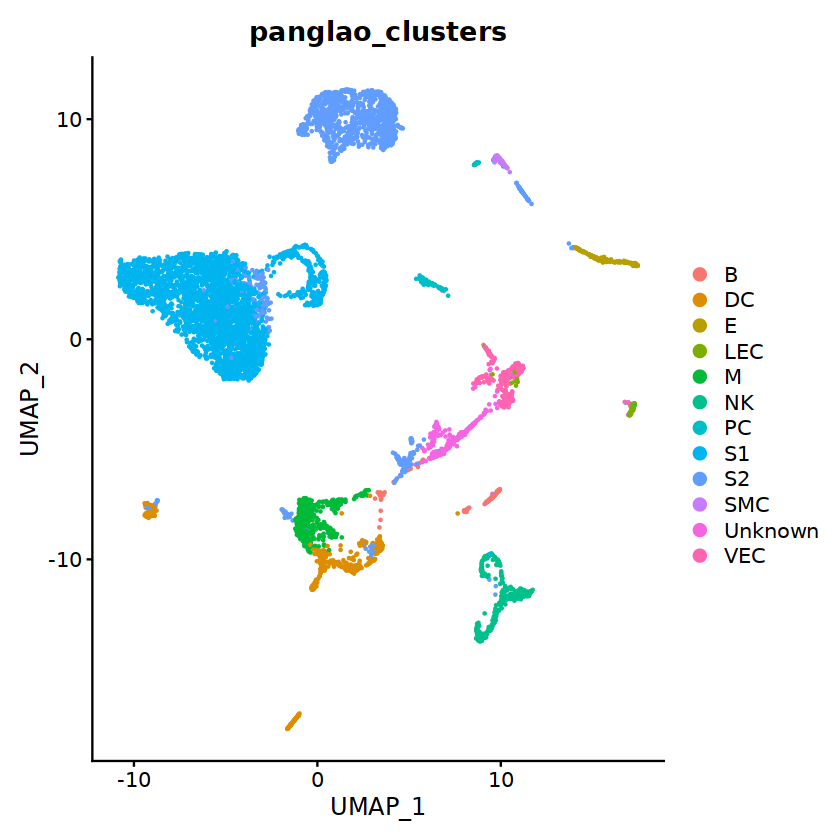

In [20]:
# View the clusters.
DimPlot(stProc, group.by='panglao_clusters')

## Step 4: Analyze the marker genes between the single-cell dataset and Yang's markers

Ideally, there should be a high degree of overlap between Yang's marker genes and the genes that are upregulated in each of these clusters. Let's find all markers in Seurat and see the degree of agreement here.

### Step 4a: Analyze marker gene overlap

Do precisely what was stated above: Across all clusters among the atlas and the imputed single-cell data, see how many genes overlap between each cluster and see if overlapping genes are regulated in the same way.

In [21]:
# Find all marker genes for the Yang data. Clone the object here so we can rename the idents safely.
# WARNING: this cell takes a long time to execute.
yangData = stProc
Idents(yangData) = yangData[['panglao_clusters']]
allMarkersYang = FindAllMarkers(yangData, verbose=FALSE)
head(allMarkersYang)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ENSMUSG00000027398,0,4.903034,0.705,0.044,0,DC,ENSMUSG00000027398
ENSMUSG00000060586,0,3.729022,0.720,0.115,0,DC,ENSMUSG00000060586
ENSMUSG00000030579,0,3.430550,0.989,0.156,0,DC,ENSMUSG00000030579
ENSMUSG00000046805,0,2.798296,0.819,0.077,0,DC,ENSMUSG00000046805
ENSMUSG00000026395,0,2.690986,0.949,0.144,0,DC,ENSMUSG00000026395
ENSMUSG00000060063,0,2.675171,0.867,0.136,0,DC,ENSMUSG00000060063


In [22]:
# Convert Yang marker table into one having both MGI and ENSEMBL.
# Use the default mappingTable.
mapperTable = dmSC::createDefaultMapperTable(toEnsembl=FALSE)[['mapperTable']]
reverseMapperTable = mapperTable[,c(2,1)]
colnames(reverseMapperTable) = c("V1", "V2")
processMarkerTable = function(markerTable) {
    if (!('ENSEMBL_ID' %in% colnames(markerTable))) {
        colnames(markerTable)[colnames(markerTable) == 'gene'] = 'ENSEMBL_ID'
    }
    if (!('MGI' %in% colnames(markerTable))) {
        markerTable[['MGI']] = applyMapper(markerTable[['ENSEMBL_ID']], mapperTable=mapperTable)
    }
    # Ensure only significant relationships captured.
    markerTable = markerTable[markerTable[['p_val_adj']] < 0.05,]
    return(markerTable)
}
allMarkersYang = processMarkerTable(allMarkersYang)
head(allMarkersYang)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,ENSEMBL_ID,MGI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
ENSMUSG00000027398,0,4.903034,0.705,0.044,0,DC,ENSMUSG00000027398,Il1b
ENSMUSG00000060586,0,3.729022,0.720,0.115,0,DC,ENSMUSG00000060586,H2-Eb1
ENSMUSG00000030579,0,3.430550,0.989,0.156,0,DC,ENSMUSG00000030579,Tyrobp
ENSMUSG00000046805,0,2.798296,0.819,0.077,0,DC,ENSMUSG00000046805,Mpeg1
ENSMUSG00000026395,0,2.690986,0.949,0.144,0,DC,ENSMUSG00000026395,Ptprc
ENSMUSG00000060063,0,2.675171,0.867,0.136,0,DC,ENSMUSG00000060063,Alox5ap


In [23]:
# Modify cell markers to share appearange of above.
allMarkersYangGT = cellMarkers
names(allMarkersYangGT) = c("gene", "p_val", "avg_log2FC", "pct.1", "pct.2", "p_val_adj", "cluster")
allMarkersYangGT[['gene']] = dmSC::applyMapper(allMarkersYangGT[['gene']], mapperTable=reverseMapperTable)
allMarkersYangGT = processMarkerTable(allMarkersYangGT)
head(allMarkersYangGT)

ENSEMBL_ID,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,MGI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSMUSG00000003379,7.966442e-212,3.392996,0.895,0.028,1.622446e-207,B,Cd79a
ENSMUSG00000076609,6.015417e-21,3.251981,0.895,0.532,1.225100e-16,B,Igkc
ENSMUSG00000076617,1.234333e-62,3.155810,0.921,0.123,2.513843e-58,B,Ighm
ENSMUSG00000040592,5.311253e-289,2.788107,0.868,0.018,1.081690e-284,B,Cd79b
ENSMUSG00000076937,0.000000e+00,2.682382,0.684,0.006,0.000000e+00,B,Iglc2
ENSMUSG00000024673,0.000000e+00,2.596779,0.763,0.001,0.000000e+00,B,Ms4a1


In [24]:
# Make Venn diagrams for each cluster.
sortedLevels = sort(levels(Idents(yangData)))
diagramInfo = list()
markersAtlasList = list()
markersSCList = list()

for (level in sortedLevels) {  
    # Find all positive and negaqtive marker genes for F1 surpassing the default criteria.
    markersAtlas = allMarkersYangGT[allMarkersYangGT[['cluster']] == level,]
    markersSC = allMarkersYang[allMarkersYang[['cluster']] == level,]
    
    # Do a comparison of genes that are common to both, genes only in one, genes only in other.
    commonGenes = intersect(markersAtlas[['ENSEMBL_ID']], markersSC[['ENSEMBL_ID']])
    allGenes = union(markersAtlas[['ENSEMBL_ID']], markersSC[['ENSEMBL_ID']])
    exclusiveAtlas = setdiff(markersAtlas[['ENSEMBL_ID']], commonGenes)
    exclusiveSC = setdiff(markersSC[['ENSEMBL_ID']], commonGenes)
    commonGenesCount = length(commonGenes)
    exclusiveAtlasCount = length(exclusiveAtlas)
    exclusiveSCCount = length(exclusiveSC)
    allGenesCount = length(allGenes)
    
    # Of the common genes, see how many have the same sign.
    markerTableAtlas = data.table(V1=markersAtlas[['ENSEMBL_ID']], V2=markersAtlas[['avg_log2FC']])
    markerTableSC = data.table(V1=markersSC[['ENSEMBL_ID']], V2=markersSC[['avg_log2FC']])
    changesAtlas = dmSC::applyMapper(commonGenes, mapperTable=markerTableAtlas)
    changesSC = dmSC::applyMapper(commonGenes, mapperTable=markerTableSC)
    sameDirection = sign(changesAtlas) == sign(changesSC)
    diffDirection = !sameDirection
    commonSameDirCount = sum(sameDirection)
    commonDiffDirCount = sum(diffDirection)
    
    # Find the top n positive markers in the atlas and SC.
    n = 5
    topMarkersAtlas = (markersAtlas %>% slice_max(order_by=avg_log2FC, n=n))[['MGI']]
    topMarkersSC = (markersSC %>% slice_max(order_by=avg_log2FC, n=n))[['MGI']]
    topMarkersAtlas = paste0(topMarkersAtlas, collapse=', ')
    topMarkersSC = paste0(topMarkersSC, collapse=', ')
    
    # Update the list.
    diagramInfo[[level]] = list(allGenes=allGenesCount,
                                commonGenes=commonGenesCount,
                                commonSameDir=commonSameDirCount,
                                commonDiffDir=commonDiffDirCount,
                                exclusiveAtlas=exclusiveAtlasCount,
                                exclusiveSC=exclusiveSCCount,
                                topMarkersAtlas=topMarkersAtlas,
                                topMarkersSC=topMarkersSC)
    markersAtlasList[[level]] = markersAtlas
    markersSCList[[level]] = markersSC
}

# Package the summary results in a data frame.
diagramTbl = as.data.frame(bind_rows(diagramInfo))
rownames(diagramTbl) = names(diagramInfo)
diagramTbl

,allGenes,commonGenes,commonSameDir,commonDiffDir,exclusiveAtlas,exclusiveSC,topMarkersAtlas,topMarkersSC
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
B,2995,51,50,1,83,2861,"Cd79a, Igkc, Ighm, Cd79b, Iglc2","Igkc, Igha, Jchain, Ighm, Sec11c"
DC,2581,681,681,0,138,1762,"Cd74, H2-Ab1, H2-Aa, H2-Eb1, Il1b","Il1b, Cd74, H2-Ab1, H2-Aa, H2-Eb1"
E,2144,139,138,1,136,1869,"NA, Lars2, S100g, NA, Sprr2f","S100g, Krt18, Ifitm1, Gng12, Mt1"
LEC,1386,647,647,0,129,610,"NA, Mmrn1, Cldn5, Lyve1, Prox1","Lyve1, Fgl2, Timp3, Cavin2, Fxyd6"
M,2393,707,707,0,100,1586,"Apoe, C1qa, Lyz2, C1qb, C1qc","Apoe, C1qa, C1qb, Lyz2, C1qc"
NK,2300,364,364,0,75,1861,"Gzma, Ccl5, Nkg7, Klra1, Gzmb","AW112010, Cd52, Vps37b, Il2rb, S100a4"
PC,1150,478,478,0,182,490,"Acta2, Rgs5, Tagln, Myl9, Mustn1","Rgs5, Acta2, Myl9, Tagln, Crip1"
S1,1539,466,466,0,18,1055,"Igf1, Fst, Hsd11b2, Angptl7, Zbtb20","Igf1, Angptl7, Fst, Hsd11b2, Zbtb20"
S2,1473,604,604,0,38,831,"Lum, C3, Gsn, Col1a2, Aebp1","Lum, Col1a2, Gsn, C3, Postn"


### Step 4b: See marker gene duplication in atlas

Among the marker genes for each cell type in the atlas, see if genes appear across more than one cluster.

In [25]:
# Group clusters per marker.
clusters_per_marker <- allMarkersYangGT[,c('cluster','MGI')] %>% group_by(MGI) %>% group_modify(function(x, y) {
    return(data.frame(clusters = paste0(unlist(x), collapse=", ")))
})

# Get rid of genes that didn't have a valid MGI symbol.
clusters_per_marker <- clusters_per_marker[!is.na(clusters_per_marker[["MGI"]]),]

# Show the clusters per marker.
head(clusters_per_marker)

MGI,clusters
<chr>,<chr>
0610012G03Rik,E
1110008P14Rik,"LEC, T"
1110059E24Rik,"VEC, PC"
1110065P20Rik,SMC
1500009L16Rik,PC
1700017B05Rik,pDC


cluster_count,n
<int>,<int>
1,2342
2,1132
3,513
4,228
5,128
6,66
7,33
8,9
9,3


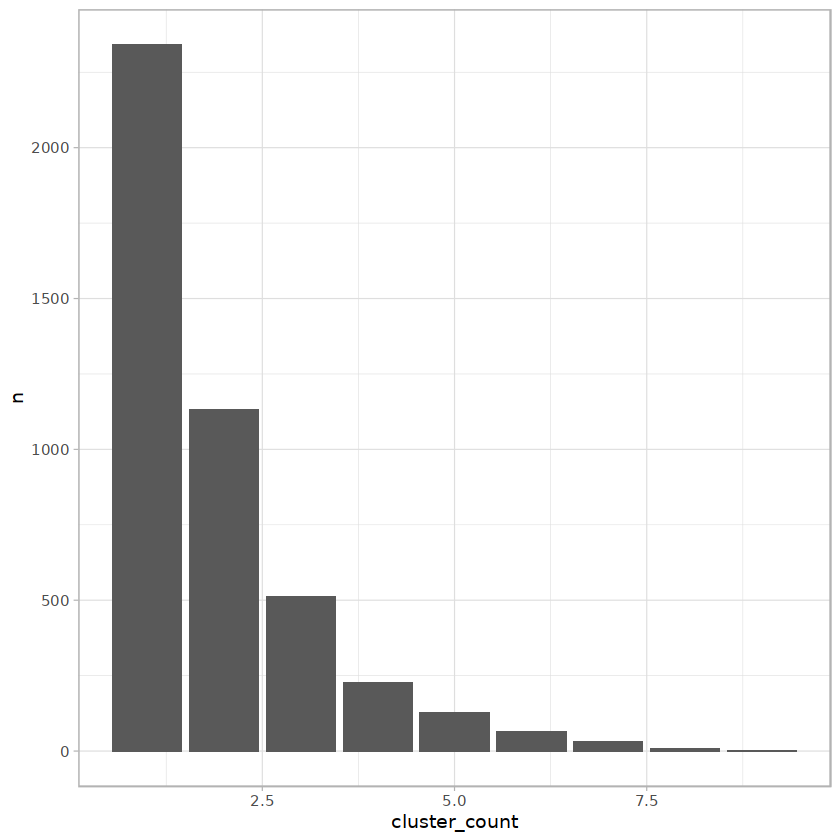

In [26]:
# Plot a histogram of how many genes occurred more than once.
clusters_per_marker_hist = allMarkersYangGT[,c('cluster','MGI')] %>% group_by(MGI) %>% filter(!is.na(MGI)) %>%
    count(name = "cluster_count") %>% group_by(cluster_count) %>% count()
ggplot(clusters_per_marker_hist, aes(x=cluster_count, y=n)) + geom_bar(stat="identity") + theme_light()
clusters_per_marker_hist

In [27]:
# Save the data.
fwrite(clusters_per_marker, file = "./analysis/112223-ClustersPerMarker-Top20.csv")

## Step 5: Subcluster each of the main clusters and perform fine-grained clustering (pending)

Repeat the above with coarser labels for Yang's clusters after discussing with Ryan. Following that, subcluster each of the big clusters and use canonical marker genes to determine cell types.